In [1]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, AutoencoderKL
import torch
import datetime

/home/umeda-yuusuke469/Diffuser/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
vae = AutoencoderKL.from_pretrained("./models/counterfeit_vae")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [4]:
pipe = StableDiffusionPipeline.from_ckpt(
    "./models/checkpoints/Counterfeit-V3.0.safetensors",
)

global_step key not found in model
In this conversion only the non-EMA weights are extracted. If you want to instead extract the EMA weights (usually better for inference), please make sure to add the `--extract_ema` flag.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.19.layer_norm2.bias', 'vision_model.encoder.layers.2.mlp.fc1.bias', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.self_attn.v_proj.weight', 'vision_model.encoder.layers.18.self_attn.q_proj.weight', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.encoder.layers.6.mlp.fc2.bias', 'vision_model.encoder.layers.17.layer_norm1.bias', 'vision_model.encoder.layers.21.self_attn.out_proj.weight', 'vision_model.encoder.layers.0.self_attn.out_proj.weight', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encoder.layers.9.self_attn.out_proj.weight', 'vision_model.encoder.layers.21.self_attn.k_proj.weight', 'vision_model.encoder.layers.1.layer_norm1.bias', 'vision_model.encoder.layers.23.self_attn.q_proj.weight', 'vision_model.enco

In [5]:
pipe.load_textual_inversion("./models/embeddings/EasyNegativeV2.safetensors", weight_name="EasyNegativeV2.safetensors", token="EasyNegativeV2")
pipe.load_textual_inversion("./models/embeddings/negative_hand-neg.pt", weight_name="negative_hand-neg.pt", token="negative_hand-neg")

The loaded token: emb_params is overwritten by the passed token EasyNegativeV2.
The loaded token: negative_hand is overwritten by the passed token negative_hand-neg.


In [6]:
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

In [7]:
pipe.vae = vae

In [8]:
def null_safety(images, **kwargs):
	return images, False

pipe.safety_checker = null_safety

In [9]:
# cuda用
pipe.enable_xformers_memory_efficient_attention()
# RAMが64GB未満の場合に推奨
# pipe.enable_attention_slicing()

In [10]:
pipe = pipe.to("cuda")

In [11]:
prompt = "(masterpiece, best quality),(((from below, depth of field, dutch angle, green lighting))), floating hair, 1girl, solo, formal, hand in pocket, suit, black gloves, building, looking at viewer, black necktie, fingerless gloves, white shirt, city, outdoors, black jacket, belt, black pants, collared shirt, brown eyes, standing, long sleeves, grey hair, cityscape, open jacket, cowboy shot, skyscraper, black suit, night, pant suit, very long hair"
negative_prompt = "EasyNegativeV2, negative_hand-neg,(worst quality:1.4), (low quality:1.4), (monochrome:1.1),text,watermark"

generator = torch.Generator(device="cuda").manual_seed(0)

image = pipe(
    prompt, 
    negative_prompt=negative_prompt, 
    num_inference_steps=25,
    generator=generator,
    guidance_scale=10,
    # width=512,
    # height=512,
    ).images[0]

Token indices sequence length is longer than the specified maximum sequence length for this model (114 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['red shirt, brown eyes, standing, long sleeves, grey hair, cityscape, open jacket, cowboy shot, skyscraper, black suit, night, pant suit, very long hair']
100%|██████████| 25/25 [00:04<00:00,  5.26it/s]


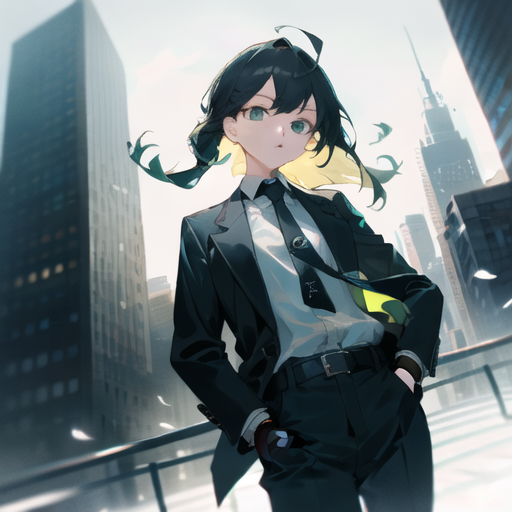

In [12]:
image